In [1]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
import xgboost as XGB
import pandas as pd
import numpy as np
from bench_util import *
import matplotlib.pyplot as plt
import xgboost as xgb
import re
import seaborn as sns
import _pickle as cPickle
from bs4 import BeautifulSoup
%matplotlib inline

/home/admin0/.pyenv/versions/miniconda3-latest/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[nltk_data] Downloading package stopwords to /home/admin0/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Benchmark TA-60
Basically, it's just the competition tutorial but you have to pay additional effort to beat it.

## Feature Extraction
 * for text features: HashVectorizer(1~4-grams) + WordStemming + StopwordsRemoval

## Model
 * SGDClassifier: logistic classifer + log-loss with batch_size=10000

[2000/27643] done
[4000/27643] done
[6000/27643] done
[8000/27643] done
[10000/27643] done
[12000/27643] done
[14000/27643] done
[16000/27643] done
[18000/27643] done
[20000/27643] done
[22000/27643] done
[24000/27643] done
[26000/27643] done
[28000/27643] done
test auc: 0.5490290796409336


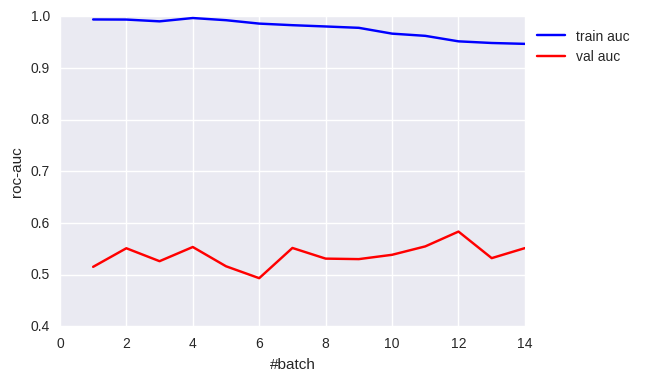

In [2]:
# use HashVectorizer to generate word-frequency features
hashvec = HashingVectorizer(decode_error='ignore', n_features=2**20,
                            ngram_range=(1,4),
                            preprocessor=preprocessor, tokenizer=tokenizer_stem_nostop)
# training by online logistic regression
clf = SGDClassifier(loss='log', n_iter=100)
# set mini-batch size
batch_size = 1000
# generate data stream
stream = get_stream(path='datasets/train_v2.csv', size=batch_size)
classes = np.array([0, 1])
# start training
train_auc, val_auc = [], []
epochs = int((27643+batch_size-1)/(batch_size*2))
for i in range(epochs):
    batch = next(stream)
    X_train, y_train = batch['Page content'], batch['Popularity'].apply(lambda x: 1 if x == 1 else 0)
    if X_train is None:
        break
    X_train = hashvec.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)
    train_auc.append(roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]))
    # validate
    batch = next(stream)
    X_val, y_val = batch['Page content'], batch['Popularity'].apply(lambda x: 1 if x == 1 else 0)
    val_auc.append(roc_auc_score(y_val, clf.predict_proba(hashvec.transform(X_val))[:,1]))
    print('[{}/{}] done'.format((i+1)*(batch_size*2), 27643))

# visualize training history
plt.plot(range(1, len(train_auc)+1), train_auc, color='blue', label='train auc')
plt.plot(range(1, len(train_auc)+1), val_auc, color='red', label='val auc')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.xlabel('#batch')
plt.ylabel('roc-auc')
# testing
df_test = pd.read_csv('datasets/test_v2.csv')
pred = clf.predict_proba(hashvec.transform(df_test['Page content']))[:,1]
print('test auc: {}'.format(roc_auc_score(df_test['Popularity'], pred)))
# generate submission
df_sub = df_test.drop(['Page content', 'Popularity'], axis=1)
df_sub['Popularity'] = pred
df_sub.to_csv('datasets/bench.csv', index=False)

From the training history, you can see the error oscillates, which means our news dataset is too complex to learn.<br>
An intuitive guess is that there may be many news with similiar contents but their popularity differs, then a question to ask is that why similiar news are sometimes popular but sometimes not?<br>
If we infer from our experience, the timing which the news published at is an important determining factor for news to be popular.

# Benchmark TA-80

As expected, among all extracted features, timing feature gives the most performance boost.

## [Feature Engineering] Augmentation

### Timing
We break the published time into 5 features, which performs much better than just using 1 feature by datetime delta(second).
 * year
 * month
 * day
 * weekday
 * hour

### Content
 * channel: type of the news, which could be extracted from HTML file
 * topic: topics of news content, which could be extracted from HTML file
 * topic_count: counts of topics
 * img_count: counts of images
 * h2_count: counts of headers
 * link_count: counts of links
 * author_count: counts of authors
 * title
 * title_len: length of title

In [3]:
def process(chunk):
    wds, chs, cimg, cvd, ch2, clk, tps, tpns, ts, tls, tlns, aths = [], [], [], [], [], [], [], [], [], [], [], []
    df = chunk.copy().drop('Page content', axis=1)
    df['Popularity'] = df['Popularity'].apply(lambda x: 1 if x==1 else 0)
    for idx, row in chunk.iterrows():
        txt = BeautifulSoup(row['Page content'], 'html.parser')
        content = str(txt.select('section.article-content')[0])
        # weekday
        wds.append(str(txt.select('time')[0]).split('"')[1].split(',')[0])
        # time 
        ts.append(str(txt.select('time')[0].get_text()))
        #channel
        chs.append(re.findall('data-channel=\"(.*)\"', row['Page content'])[0].split('"')[0])
        # topic
        tps.append(re.findall('<a href=.*?category\/(.*?)\/', row['Page content']))
        # topic num
        tpns.append(len(re.findall('<a href=.*?category\/(.*?)\/', row['Page content'])))
        # num of img
        cimg.append(len(re.findall('<img', row['Page content'])))
        # num of video
        cvd.append(len(re.findall('<iframe', row['Page content'])))
        # num of h2
        ch2.append(len(re.findall('<h2>', content)))
        # num of links
        clk.append(len(re.findall('<a href', content)))
        # title
        tls.append(str(txt.select('h1.title')[0].get_text()))
        # title length
        tlns.append(len(str(txt.select('h1.title')[0].get_text())))
        # author num
        ath = txt.select('span')
        if len(ath) > 0:
            ath = re.findall('<span.*>(.*)<\/span>', str(ath[0]))[0]
            a = re.findall('<a.*>(.*)<\/a>', ath)
            if len(a) > 0:
                ath = a[0].replace('\r','')
        else:
            ath = 'None'
        aths.append(len(ath.split(',')))
    df['weekday'] = wds
    df['channel'] = chs
    df['img_count'] = cimg
    df['video_count'] = cvd
    df['h2_count'] = ch2
    df['link_count'] = clk
    df['topic_count'] = tpns
    df['topic'] = tps
    df['time'] = ts
    df['title'] = tls
    df['title_len'] = tlns
    df['author_count'] = aths
    return df
def augment(df_path):
    rst = None
    chunksize = 10 ** 3
    for chunk in pd.read_csv(df_path, chunksize=chunksize, encoding='utf-8'):
        tdf = process(chunk)
        rst = tdf if rst is None else pd.concat([rst, tdf])
        print('[{} done]'.format(rst.shape[0]))
    rst['time'] = pd.to_datetime(pd.Series(rst['time']))
    return rst

# augment feature
ext_train = augment('datasets/train_v2.csv')
ext_test = augment('datasets/test_v2.csv')
# extract feature 'year', 'month', 'day', 'hour' from Pandas DatetimeIndex
ext_train['hour'] = pd.DatetimeIndex(ext_train['time']).hour
ext_test['hour'] = pd.DatetimeIndex(ext_test['time']).hour
ext_train['month'] = pd.DatetimeIndex(ext_train['time']).month
ext_test['month'] = pd.DatetimeIndex(ext_test['time']).month
ext_train['day'] = pd.DatetimeIndex(ext_train['time']).day
ext_test['day'] = pd.DatetimeIndex(ext_test['time']).day
ext_train['year'] = pd.DatetimeIndex(ext_train['time']).year
ext_test['year'] = pd.DatetimeIndex(ext_test['time']).year

# backup
ext_train.to_csv('datasets/ext_train_v2.csv', index=False)
ext_test.to_csv('datasets/ext_test_v2.csv', index=False)

[1000 done]
[2000 done]
[3000 done]
[4000 done]
[5000 done]
[6000 done]
[7000 done]
[8000 done]
[9000 done]
[10000 done]
[11000 done]
[12000 done]
[13000 done]
[14000 done]
[15000 done]
[16000 done]
[17000 done]
[18000 done]
[19000 done]
[20000 done]
[21000 done]
[22000 done]
[23000 done]
[24000 done]
[25000 done]
[26000 done]
[27000 done]
[27643 done]
[1000 done]
[2000 done]
[3000 done]
[4000 done]
[5000 done]
[6000 done]
[7000 done]
[8000 done]
[9000 done]
[10000 done]
[11000 done]
[11847 done]


## Data Exploration

In [4]:
ext_train = pd.read_csv('datasets/ext_train_v2.csv')
ext_test = pd.read_csv('datasets/ext_test_v2.csv')
ext_train.describe()

,Id,Popularity,img_count,video_count,h2_count,link_count,topic_count,title_len,author_count,hour,month,day,year
count,27643.000000,27643.000000,27643.000000,27643.000000,27643.000000,27643.000000,27643.000000,27643.000000,27643.000000,27643.000000,27643.000000,27643.000000,27643.000000
mean,13821.000000,0.493145,5.853923,1.262019,0.569150,10.980610,6.957277,53.882827,1.012878,14.030026,6.613609,15.726368,2013.541728
std,7979.991082,0.499962,8.324813,4.129748,2.234762,11.310743,2.951410,11.597389,0.118081,6.601632,3.387915,8.629610,0.498337
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,1.000000,0.000000,1.000000,1.000000,2013.000000
25%,6910.500000,0.000000,2.000000,0.000000,0.000000,4.000000,5.000000,46.000000,1.000000,11.000000,4.000000,8.000000,2013.000000
50%,13821.000000,0.000000,2.000000,0.000000,0.000000,7.000000,7.000000,54.000000,1.000000,16.000000,7.000000,16.000000,2014.000000
75%,20731.500000,1.000000,6.000000,1.000000,0.000000,14.000000,9.000000,62.000000,1.000000,19.000000,10.000000,23.000000,2014.000000
max,27642.000000,1.000000,112.000000,91.000000,59.000000,304.000000,43.000000,112.000000,4.000000,23.000000,12.000000,31.000000,2015.000000


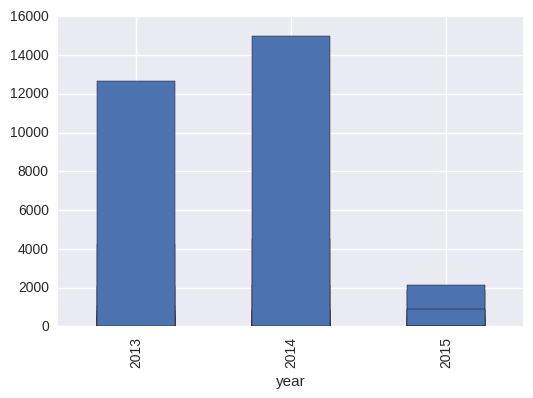

In [5]:
for c in ['weekday', 'hour', 'channel', 'topic_count', 'month', 'day', 'year']:
    ext_train.groupby(c).size().plot(kind='bar')
    plt.savefig('imgs/{}.png'.format(c))

Take a look at images at `imgs/`, this motivates us to do the following feature aggregation:
 * 'weekday': comparing to weekdays, fewer news are published on Saturday and Sunday<br>
   => aggregate values of published weekday of type Saturday and Sunday into a new type `Weekend`
 * 'hour': diverges<br>
   => aggregate into 4 intervals: `morning`, `afternoon`, `night`, and `midnight`
 * 'channel': too many types<br>
   => aggregate into 5 channels: `world`, `tech`, `entertainment`, `business`, `lifestyle`

After doing above feature aggregation, it gives about 5% improvement in performance.

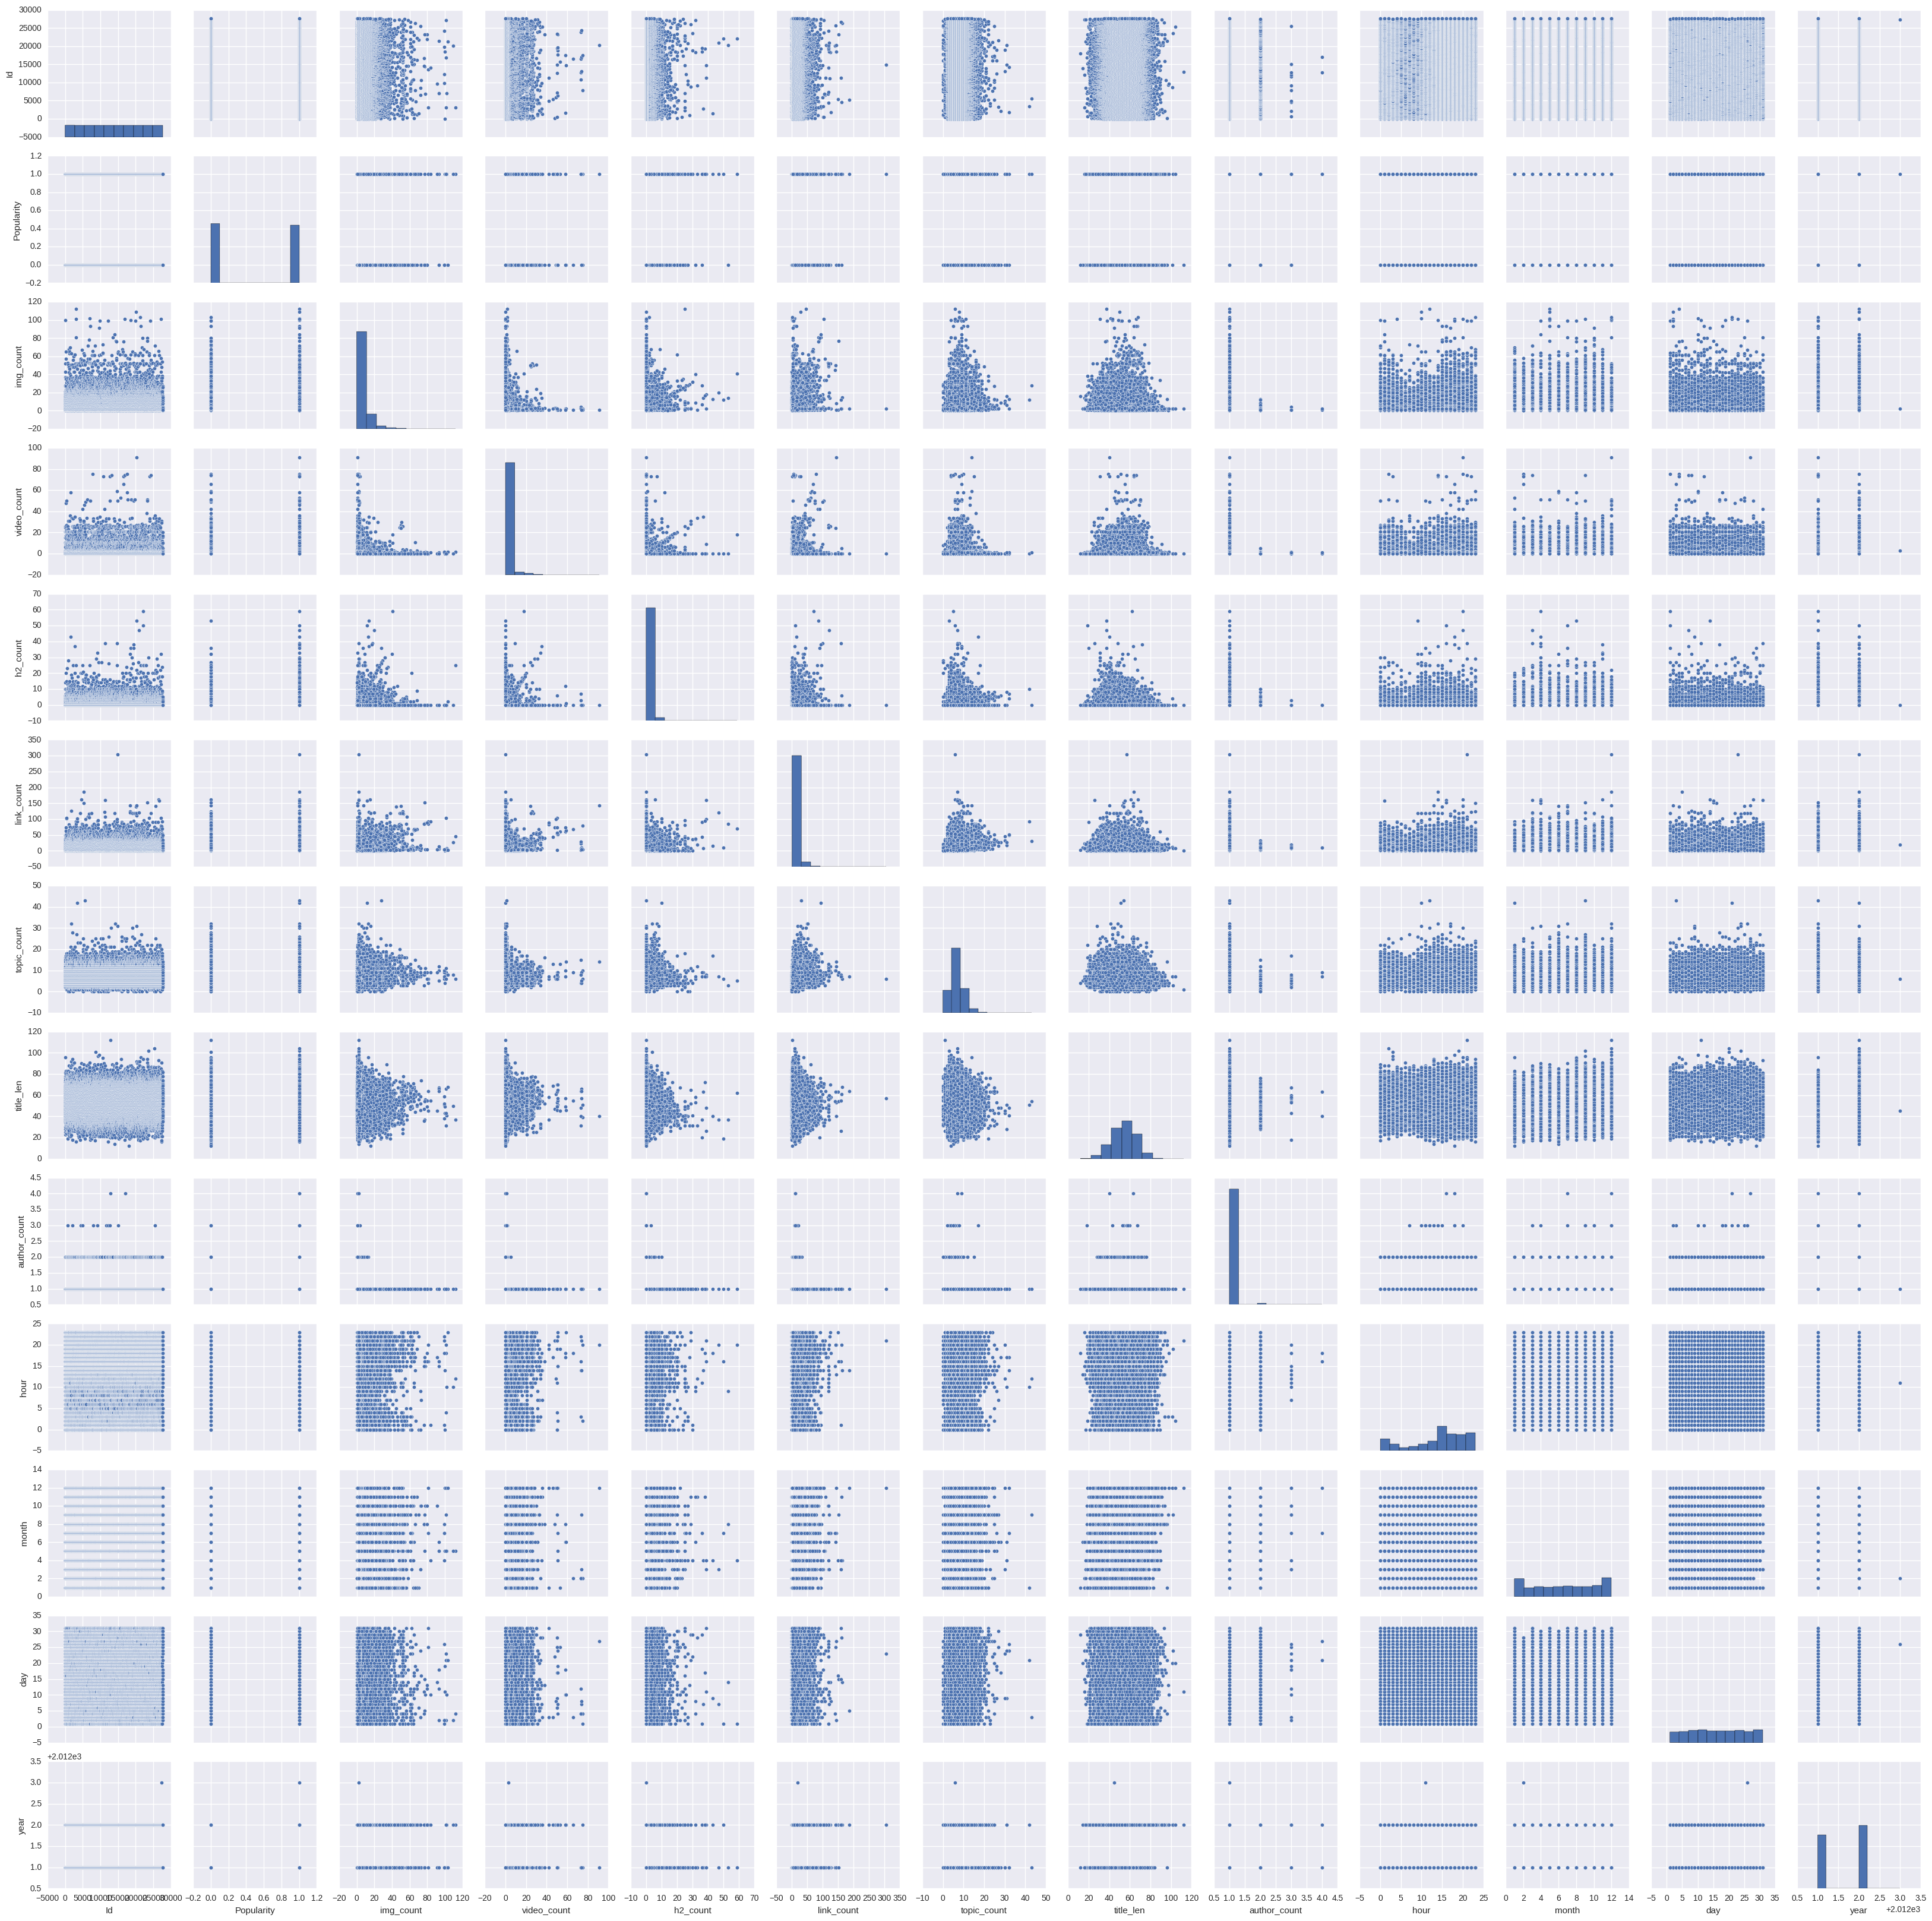

In [6]:
sns.set()
sns_plot = sns.pairplot(ext_train)
sns_plot.savefig("imgs/extracted_pairplot.png")

Although it looks very noisy, there're several readable patterns:
 * for `img_counts`, `video_counts`, `link_counts`, `author_counts`, the news must be popular if the counts are larger than a threshold.
 * for `title_length` larger than a threshold, the news must be unpopular

, which aligns with our experience, cool! :D

## [Feature Engineering] Encoding Categorical Features
One-Hot Encoding
 * year
 * month
 * day
 * weekday
   * (+) 'Weekend': if 'Sat' or 'Sun'
 * hour
   * (+) 'morning': if 7~12h
   * (+) 'afternoon' if 13~18h
   * (+) 'night': if 19~24h
   * (+) 'midnight': if 1~6h
 * channel
   * (+) 'world': if 'world', 'us', 'socmed'
   * (+) 'tech': if 'tech', 'watercooler', 'gadgets', 'apps-software', 'mobile', 'dev-design', 'viral', 'mob'
   * (+) 'entertainment': if 'entertainment', 'music', 'gaming', 'pics', 'film', 'sports', 'comics'
   * (+) 'business': if 'startups', 'business', 'marketing', 'bus', 'jobs', 'advertising', 'small-business'
   * (+) 'lifestyle': if 'social-media','media', 'lifestyle', 'how-to', 'conversations', 'home','memes', 'howto'
   
## [Feature Engineering] Scaling Numerical Features
Standardize
 * img_count
 * h2_count
 * link_count
 * author_count
 * title_len
 * topic_count

In [7]:
# one-hot encode categorical features
def onehot(df_ext):
    df_ext = df_ext.fillna(0)
    wds = df_ext['weekday'].unique()
    chs = df_ext['channel'].unique()
    hs = df_ext['hour'].unique()
    ms = df_ext['month'].unique()
    ds = df_ext['day'].unique()
    ys = df_ext['year'].unique()
    df_aug = df_ext.copy().drop(['weekday', 
        'channel', 'topic', 'year', 'month', 'day', 'hour'], axis=1)
    for w in wds:
        df_aug[w] = 0
    df_aug['Weekend'] = 0
    for ch in chs:
        df_aug[ch] = 0
    for m in ms:
        df_aug['M{}'.format(int(m))] = 0
    for d in ds:
        df_aug['d{}'.format(int(d))] = 0
    for y in ys:
        df_aug[y] = 0
    for h in hs:
        df_aug['{}h'.format(int(h))] = 0
    for h in ['morning', 'afternoon', 'night', 'midnight']:
        df_aug[h] = 0
    for i in range(df_aug.shape[0]):
        df_aug.set_value(i, df_ext.iloc[i]['weekday'], 1)
        df_aug.set_value(i, '{}h'.format(int(df_ext.iloc[i]['hour'])), 1)
        df_aug.set_value(i, df_ext.iloc[i]['channel'], 1)
        df_aug.set_value(i, df_ext.iloc[i]['year'], 1)
        df_aug.set_value(i, 'M{}'.format(int(df_ext.iloc[i]['month'])), 1)
        df_aug.set_value(i, 'd{}'.format(int(df_ext.iloc[i]['day'])), 1)
        if df_ext.iloc[i]['weekday'] in ['Sat', 'Sun']:
            df_aug.set_value(i, 'Weekend', 1)
        # aggregate: hour
        if df_ext.iloc[i]['hour'] in range(7, 13):
            df_aug.set_value(i, 'morning', 1)
        elif df_ext.iloc[i]['hour'] in range(13, 19):
            df_aug.set_value(i, 'afternoon', 1)
        elif df_ext.iloc[i]['hour'] in range(19, 24):
            df_aug.set_value(i, 'night', 1)
        else:
            df_aug.set_value(i, 'midnight', 1)
        # aggregate: channel
        if df_ext.iloc[i]['channel'] in ['world', 'us', 'socmed']:
            df_aug.set_value(i, 'world', 1)
        elif df_ext.iloc[i]['channel'] in ['tech', 'watercooler', 'gadgets', 
            'apps-software', 'mobile', 'dev-design', 'viral', 'mob']:
            df_aug.set_value(i, 'tech', 1)
        elif df_ext.iloc[i]['channel'] in ['entertainment', 'music', 'gaming',
            'pics', 'film', 'sports', 'comics']:
            df_aug.set_value(i, 'entertainment', 1)
        elif df_ext.iloc[i]['channel'] in ['startups', 'business', 'marketing',
            'bus', 'jobs', 'advertising', 'small-business']:
            df_aug.set_value(i, 'business', 1)
        elif df_ext.iloc[i]['channel'] in ['social-media','media', 'lifestyle', 
            'how-to', 'conversations', 'home','memes', 'howto']:
            df_aug.set_value(i, 'lifestyle', 1)
    return df_aug

aug_all = pd.concat([ext_train, ext_test])
print('before encoding col_num: {}'.format(len(aug_all.columns)))
aug_all.set_index('Id', inplace=True)
aug_all = onehot(aug_all)
print('after encoding col_num: {}'.format(len(aug_all.columns)))
aug_train = aug_all.iloc[:ext_train.shape[0]]
aug_test = aug_all.iloc[ext_train.shape[0]:]
aug_test = aug_test.fillna(0)
print('check missing value of train set: {}'.format(aug_train.isnull().T.any().T.sum()))
print('check missing value of test set: {}'.format(aug_test.isnull().T.any().T.sum()))

# scale numerical feature
for c in ['img_count', 'video_count', 'h2_count', 'link_count', 'topic_count', 'author_count', 'title_len']:
    m, std = aug_train[c].mean(), aug_train[c].std()
    aug_train[c] = (aug_train[c]-m) / std
    aug_test[c] = (aug_test[c]-m) / std

# backup
aug_train.to_csv('datasets/alg_train_v2.csv', index=False)
aug_test.to_csv('datasets/alg_test_v2.csv', index=False)

aug_train.describe()

before encoding col_num: 18
after encoding col_num: 130
check missing value of train set: 0
check missing value of test set: 0


/home/admin0/.pyenv/versions/miniconda3-latest/lib/python3.5/site-packages/ipykernel/__main__.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Popularity,img_count,video_count,h2_count,link_count,topic_count,title_len,author_count,Wed,Thu,...,11h,12h,8h,7h,6h,10h,morning,afternoon,night,midnight
count,27643.000000,2.764300e+04,2.764300e+04,2.764300e+04,2.764300e+04,2.764300e+04,2.764300e+04,2.764300e+04,27643.000000,27643.000000,...,27643.000000,27643.000000,27643.000000,27643.000000,27643.000000,27643.000000,27643.000000,27643.000000,27643.000000,27643.000000
mean,0.493145,-3.791378e-17,-6.683106e-18,2.133453e-17,-3.984160e-17,3.084511e-17,-9.664800e-17,-2.398207e-16,0.187389,0.185291,...,0.032486,0.034511,0.011649,0.012300,0.011576,0.023876,0.129436,0.397931,0.291647,0.180986
std,0.499962,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.390231,0.388541,...,0.177289,0.182542,0.107300,0.110222,0.106970,0.152665,0.335688,0.489480,0.454529,0.385014
min,0.000000,-7.031897e-01,-3.055924e-01,-2.546802e-01,-9.708124e-01,-2.357272e+00,-3.611401e+00,-1.090649e-01,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-4.629441e-01,-3.055924e-01,-2.546802e-01,-6.171663e-01,-6.631666e-01,-6.797071e-01,-1.090649e-01,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,-4.629441e-01,-3.055924e-01,-2.546802e-01,-3.519318e-01,1.447555e-02,1.010335e-02,-1.090649e-01,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.754715e-02,-6.344681e-02,-2.546802e-01,2.669489e-01,6.921177e-01,6.999138e-01,-1.090649e-01,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.275057e+01,2.172965e+01,2.614634e+01,2.590629e+01,1.221203e+01,5.011229e+00,2.529724e+01,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
aug_train = aug_train.drop(['time', 'title'], axis=1)
aug_test = aug_test.drop(['time', 'title'], axis=1)

X_train = aug_train.drop(['Popularity'], axis=1)
X_test = aug_test.drop(['Popularity'], axis=1)
y_train = aug_train['Popularity']
y_test = aug_test['Popularity']

clf1 = LogisticRegression(penalty='l1', C=1e-1)
clf2 = RandomForestClassifier(n_estimators=50)
clf3 = KNeighborsClassifier(n_neighbors=5, weights='uniform')
clf4 = SVC(kernel='poly', probability=True, C=35, gamma=0.0055, coef0=0.1, degree=2)

print('[LR] CV-score: {}'.format(cross_val_score(clf1, X_train, y_train).mean()))
print('[RF] CV-score: {}'.format(cross_val_score(clf2, X_train, y_train).mean()))
print('[KNN] CV-score: {}'.format(cross_val_score(clf3, X_train, y_train).mean()))
print('[SVC] CV-score: {}'.format(cross_val_score(clf4, X_train, y_train).mean()))

[LR] CV-score: 0.5632166727654957
[RF] CV-score: 0.5496509730664956
[KNN] CV-score: 0.5318524230213736
[SVC] CV-score: 0.5641572900360837


## [Feature Engineering] Extracting Text Feature
Text feature extracted by the following ways performs similiarly
 * Latent Semantic Indexing: Tf-Idf + SVD
   * best-dimension: 100
 * Topic Modeling: Latent Dirichlet Allocation
   * best-dimension: 50
 * Document Embedding: doc2vec
   * best-dimension: 16

We adopted the doc2vec implemented by Gensim in `TA-80`.

In [ ]:
import gensim

def remove(text):
    text = preprocessor(text)
    return text.replace('\n', ' ')

def read_corpus(fname, tokens_only=False):
    with open(fname, encoding='utf-8') as f:
        for i, line in enumerate(f):
            if tokens_only:
                yield gensim.utils.simple_preprocess(line)
            else:
                yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(line), [i])
# read dataset
df_train, df_test = pd.read_csv('datasets/train_v2.csv'), pd.read_csv('datasets/test_v2.csv')
df_train['Popularity'] = df_train['Popularity'].apply(lambda x: 1 if x==1 else 0)
# prepare documents for gensim
s_train = '\n'.join(df_train['Page content'].apply(remove))
with open('datasets/page_train.txt', 'w+') as f:
    f.write(s_train)
s_test = '\n'.join(df_test['Page content'].apply(remove))
with open('datasets/page_test.txt', 'w+') as f:
    f.write(s_test)
# training Doc2Vec
train_corpus = list(read_corpus('datasets/page_train.txt'))
test_corpus = list(read_corpus('datasets/page_test.txt'))
model = gensim.models.doc2vec.Doc2Vec(size=16, min_count=1, iter=10)
model.build_vocab(train_corpus)
%time model.train(train_corpus)
# get mapped vector
inf_train = []
for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    inf_train.append(inferred_vector)
inf_test = []
for doc_id in range(len(test_corpus)):
    inferred_vector = model.infer_vector(test_corpus[doc_id].words)
    inf_test.append(inferred_vector)
# backup
cPickle.dump(inf_train, open('datasets/d2v_page_train.pkl', 'wb'))
cPickle.dump(inf_test, open('datasets/d2v_page_test.pkl', 'wb'))

## Augmented Features + Text Feature

In [12]:
pg_train, pg_test = cPickle.load(open('datasets/d2v_page_train.pkl','rb')), cPickle.load(open('datasets/d2v_page_test.pkl','rb'))
df_train = pd.read_csv('datasets/alg_train_v2.csv').drop(['time', 'title'], axis=1)
df_test = pd.read_csv('datasets/alg_test_v2.csv').drop(['time', 'title'], axis=1)
X_train = np.hstack([df_train.drop(['Popularity'], axis=1), pg_train])
X_test = np.hstack([df_test.drop(['Popularity'], axis=1), pg_test])
y_train = df_train['Popularity']
y_test = df_test['Popularity']

## Model: Weighted-Sum Voting
 * Logistic Regression
 * Random Forest
 * SVM
 * KNN
 * Lasso

In [13]:
X_trainS, X_val, y_trainS, y_val = train_test_split(X_train, y_train, test_size=0.3)

clf1 = LogisticRegression(penalty='l1', C=1)
clf2 = RandomForestClassifier(n_estimators=100)
clf3 = SVC(kernel='poly', probability=True, C=35, gamma=0.0055, coef0=0.1, degree=2)
clf4 = KNeighborsClassifier(n_neighbors=5)
clf5 = Lasso(alpha=1e-4, max_iter=50000)

clf1.fit(X_trainS, y_trainS)
clf2.fit(X_trainS, y_trainS)
clf3.fit(X_trainS, y_trainS)
clf4.fit(X_trainS, y_trainS)
clf5.fit(X_trainS, y_trainS)

pred1 = clf1.predict_proba(X_val)[:,1]
pred2 = clf2.predict_proba(X_val)[:,1]
pred3 = clf3.predict_proba(X_val)[:,1]
pred4 = clf4.predict_proba(X_val)[:,1]
pred5 = clf5.predict(X_val)

print('[LR] valid-auc: {}'.format(roc_auc_score(y_val, pred1)))
print('[RF] valid-auc: {}'.format(roc_auc_score(y_val, pred2)))
print('[SVC] valid-auc: {}'.format(roc_auc_score(y_val, pred3)))
print('[KNN] valid-auc: {}'.format(roc_auc_score(y_val, pred4)))
print('[Lasso] valid-auc: {}'.format(roc_auc_score(y_val, pred5)))

# select voting weight by validation set
bab, bscore = None, 0
for a in range(10):
    for b in range(10):
        for c in range(10):
            for d in range(10):
                for e in range(10):
                    y_pred = pred1*a + pred2*b + pred3*c + pred4*d + pred5*e
                    s = roc_auc_score(y_val, y_pred)
                    if bscore < s:
                        bab = (a, b, c, d, e)
                        bscore = s
print('{}: {}'.format(bab, bscore))

# train on all training data
clf1.fit(X_train, y_train)
clf2.fit(X_train, y_train)
clf3.fit(X_train, y_train)
clf4.fit(X_train, y_train)
clf5.fit(X_train, y_train)
# testing
pred1 = clf1.predict_proba(X_test)[:,1]
pred2 = clf2.predict_proba(X_test)[:,1]
pred3 = clf3.predict_proba(X_test)[:,1]
pred4 = clf4.predict_proba(X_test)[:,1]
pred5 = clf5.predict(X_test)

a, b, c, d, e = bab
y_pred = pred1*a + pred2*b + pred3*c + pred4*d + pred5*e
s = roc_auc_score(y_test, y_pred)
print('test auc: {}'.format(s))

df_sub = pd.read_csv('datasets/sample_submission_v2.csv')
df_sub['Popularity'] = y_pred
df_sub.to_csv('datasets/bench-80.csv', index=False)

[LR] valid-auc: 0.5783776646640062
[RF] valid-auc: 0.5796814879831644
[SVC] valid-auc: 0.5850986468808694
[KNN] valid-auc: 0.5399840508418677
[Lasso] valid-auc: 0.5787773242757006
(0, 7, 9, 1, 2): 0.5925793371734625
test auc: 0.5850195980874314
